# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science 

# Lab 8: Decision Trees & Bagging

**Harvard University**<br/>
**Fall 2023**<br/>
**Instructors**: Pavlos Protopapas and Kevin Rader<br/>
<hr style='height:2px'>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

Table of Contents:
- A quick review of decision trees
- `DecisionTreeClassifier`
- Tuning a single decision tree (`max_depth` & `criterion`)
- Vizualizing a decision tree with `plot_tree`)
- Pruning
- Motivating bagging
- Out-of-Bag Error (OOB)
- Feature Importance
- `BaggingClassifier`

---------

#### The Idea: Decision Trees are just flowcharts and are interpretable!

<img src="fig/flowchart.png" alt="how to fix anything" width="50%"/>


It turns out that simple flow charts can be formulated as mathematical models for classification and these models have the properties we desire:
 - interpretable by humans 
 - have sufficiently complex decision boundaries 
 - the decision boundaries are locally linear, each component of the decision boundary is simple to describe mathematically. 

----------

#### Let's review some theory.

How do we build decision trees? We use a greedy approach:
 1. Start with an empty decision tree (undivided feature space) 
 2. Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting by applying a **splitting criterion (1)**
 3. Recurse on on each new node until **stopping condition (2)** is met
 
For classification, we label each region in the model with the label of the class to which the majority of the points within the region belong. 

#### So we need a (1) splitting criterion and a (2) stopping condition:

  #### (1) Splitting criterion 
<img src="fig/split1.png" alt="split1" width="70%"/>

---

<img src="fig/classification error.png" alt="classification error"/>

---
<img src="fig/split2.png" alt="split2" width="70%"/>

<img src="fig/tree_loss.png" alt="tree_adj"/>

#### (2) Stopping condition

If we don’t terminate the decision tree learning algorithm manually, the tree will continue to grow until each region defined by the model possibly contains exactly one training point (and the model attains 100% training accuracy). **Not stopping while building a deeper and deeper tree = 100% training accuracy; What will your test accuracy be? What can we do to fix this?**

To prevent the **overfitting** from happening, we could 
- Stop the algorithm at a particular depth. (=**not too deep**)
- Don't split a region if all instances in the region belong to the same class. (=**stop when subtree is pure**)
- Don't split a region if the number of instances in the sub-region will fall below pre-defined threshold (min_samples_leaf). (=**not too specific/small subtree**)
- Don't use too many splits in the tree (=**not too many splits / not too complex global tree**)
- Be content with <100% accuracy training set...

-------------

#### Done with theory, let's get started

In [2]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import tree
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import confusion_matrix
from sklearn import datasets

#new model objects
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier


pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

np.random.seed(42)

-------------

# Part 1 : Decision Tree Spam Classifier

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Spam` that indicates whether an email is spam or not spam. The goal is to be able to create a classifier or method that acts as a spam filter.

In [3]:
spam_df = pd.read_csv('data/spam.csv')
display(spam_df.head())

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


The predictors are all quantitative. They represent certain features  of an email like the frequency of the word 'discount.' The we will use the binary `spam` variable in the final column as our response for classification.

Link to description : https://archive.ics.uci.edu/ml/datasets/spambase

### Split data into train and test

In [4]:
# Split spam_df into train and test data with a random seed of 109
data_train, data_test = train_test_split(spam_df, random_state=0, test_size=.2, stratify=spam_df.spam)

# Split predictor and response columns
X_train, y_train = data_train.drop(['spam'], axis=1), data_train['spam']
X_test , y_test  = data_test.drop(['spam'] , axis=1), data_test['spam']

print("Shape of Training Set :", data_train.shape)
print("Shape of Testing Set :" , data_test.shape)

Shape of Training Set : (3680, 58)
Shape of Testing Set : (921, 58)


In [5]:
X_train.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total
4544,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.93,0.00,0.00,0.93,0.0,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.93,0.0,0.0,0.00,0.0,0.0,0.00,0.93,0.93,0.93,0.0,0.00,0.000,0.163,0.000,0.000,0.000,0.0,1.911,15,65
219,0.00,0.00,0.48,0.0,0.96,0.00,0.0,0.00,0.48,0.0,0.00,0.00,0.0,0.00,0.00,0.96,0.96,0.00,1.44,0.0,0.48,0.0,0.96,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.48,0.00,0.0,0.00,0.000,0.133,0.066,0.468,0.267,0.0,3.315,61,242
4597,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,6.00,0.0,2.00,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,2.00,0.0,0.00,0.000,0.000,0.000,0.353,0.000,0.0,1.555,4,14
3210,0.02,0.08,0.10,0.0,0.27,0.07,0.0,0.00,0.14,0.0,0.00,0.05,0.0,0.02,0.01,0.02,0.00,0.01,0.05,0.0,0.04,0.0,0.00,0.0,0.48,0.49,0.04,0.0,0.0,0.0,0.0,0.0,0.36,0.0,0.0,0.01,0.45,0.0,0.0,0.01,0.0,0.0,0.04,0.00,0.01,0.00,0.0,0.02,0.221,0.152,0.056,0.000,0.004,0.0,2.630,38,3086
1577,0.00,0.00,0.00,0.0,1.09,0.00,0.0,0.54,0.00,0.0,0.54,1.63,0.0,0.27,0.00,0.00,0.27,0.54,2.18,0.0,0.54,0.0,0.00,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.27,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.00,0.000,0.208,0.000,0.166,0.083,0.0,3.521,114,243


We can check that the proportion of spam cases is roughly evenly represented in both the training and test set.


In [6]:
#Check Percentage of Spam in Train and Test Set
pct_spam_tr = 100*y_train.mean()
pct_spam_te = 100*y_test.mean()
                                                  
print(f"Percentage of Spam in Training Set \t : {pct_spam_tr:0.2f}%")
print(f"Percentage of Spam in Testing Set \t : {pct_spam_te:0.2f}%")

Percentage of Spam in Training Set 	 : 39.40%
Percentage of Spam in Testing Set 	 : 39.41%


-----------

# Part 2 : Fitting an Optimal Single Decision Tree (by Depth) :

Here, for each candidate `max_depth` and `criterion` combination, we fit a single tree to our spam training data using 5-fold cross validation.

We store the CV accuracy scores in a DataFrame along with the hyperparmeter settings that generated them.

In [7]:
#Find optimal depth of trees

df = pd.DataFrame(columns=['criterion', 'depth', 'all_cv', 'mean_cv'])

criterion = ['gini', 'entropy']

first_depth = 2
final_depth = 30
step = 2

results = []
for cur_criterion in criterion:      
    for max_depth in range(first_depth, final_depth+1, step):
        dt = DecisionTreeClassifier(criterion=cur_criterion , max_depth=max_depth)
        scores = cross_val_score(estimator=dt, X=X_train, y=y_train, cv=5, n_jobs=-1)
        
        cur_results = {'criterion': cur_criterion,
                      'depth': max_depth,
                      'all_cv': scores,
                      'mean_cv': scores.mean()}
        results.append(cur_results)
df = pd.DataFrame(results)

In [8]:
display(df)

,criterion,depth,all_cv,mean_cv
0,gini,2,"[0.8328804347826086, 0.8491847826086957, 0.860...",0.842663
1,gini,4,"[0.8885869565217391, 0.904891304347826, 0.9103...",0.899185
2,gini,6,"[0.9184782608695652, 0.9089673913043478, 0.925...",0.911141
3,gini,8,"[0.9225543478260869, 0.9144021739130435, 0.929...",0.918478
4,gini,10,"[0.9089673913043478, 0.9144021739130435, 0.929...",0.916033
5,gini,12,"[0.9116847826086957, 0.9157608695652174, 0.933...",0.919293
6,gini,14,"[0.9116847826086957, 0.9157608695652174, 0.925...",0.916576
7,gini,16,"[0.9035326086956522, 0.90625, 0.92119565217391...",0.912500
8,gini,18,"[0.9144021739130435, 0.907608695652174, 0.9279...",0.914402
9,gini,20,"[0.9103260869565217, 0.9130434782608695, 0.919...",0.912772


Some dataframe manipulations for our x,y construction for the plot below:

We can then visualize the validation accuracy for the different hyperparameters.

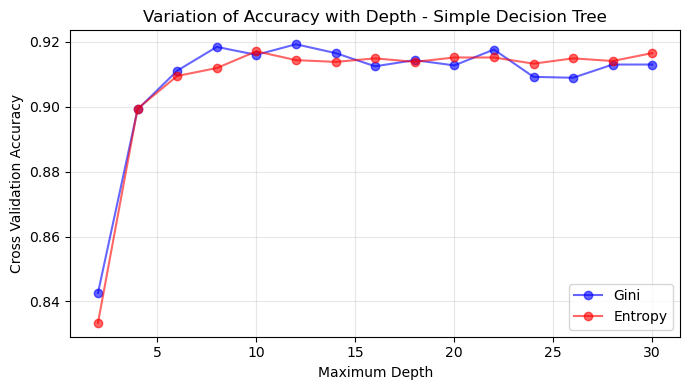

In [9]:
plt.figure(figsize=(7, 4))

plt.plot(df[df.criterion == 'gini'].depth,
         df[df.criterion == 'gini'].mean_cv, 'b-', marker='o', alpha = 0.6, label='Gini')
plt.plot(df[df.criterion == 'entropy'].depth,
         df[df.criterion == 'entropy'].mean_cv, 'r-', marker='o', alpha = 0.6, label='Entropy')
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.legend()
plt.grid(alpha = 0.3)

plt.tight_layout()
plt.show()

### Let's visualize a plot with the Confidence Bands!

Also, if we wanted to get **the Confidence Bands of these results**, how would we? It's as simple as a combination of getting variance using ```scores.std()``` and ```plt.fill_between()```.

In [10]:
df_gini = df[df['criterion'] == 'gini']
df_entropy = df[df['criterion'] == 'entropy']

x_gini = df_gini['depth'].values.astype(float)
y_gini = df_gini['mean_cv'].values.astype(float)

x_entropy = df_entropy['depth'].values.astype(float)
y_entropy = df_entropy['mean_cv'].values.astype(float)

stds_gini = np.array([ np.std(scores) for scores in df_gini['all_cv']], dtype = float) 
stds_entropy = np.array([ np.std(scores) for scores in df_entropy['all_cv']], dtype = float)

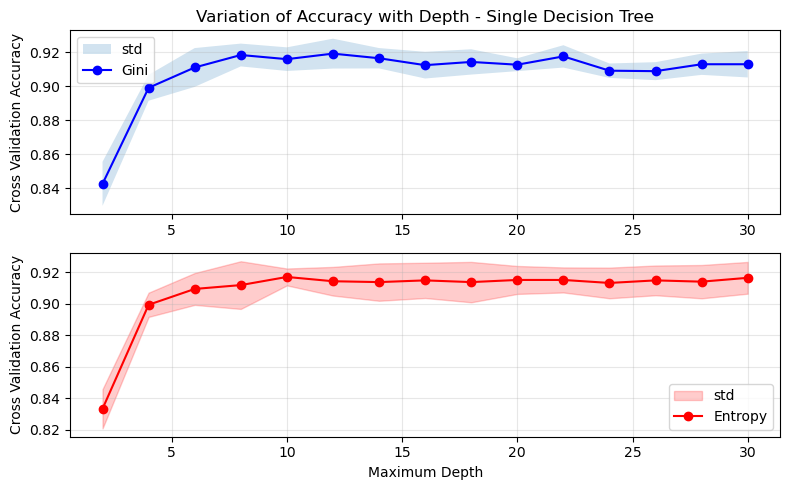

In [11]:
fig, axes = plt.subplots(2, 1, figsize=(8, 5))

#Plot
axes[0].fill_between(df.loc[df.criterion == 'gini'].depth, y_gini + stds_gini, 
                     y_gini - stds_gini, alpha=0.2)
axes[0].plot(x_gini, y_gini, 'b-', marker='o')
axes[0].set_ylabel("Cross Validation Accuracy")
axes[0].set_title('Variation of Accuracy with Depth - Single Decision Tree')
axes[0].legend(['std','Gini'])
axes[0].grid(alpha = 0.3)

axes[1].fill_between(x_entropy, y_entropy + stds_entropy, 
                     y_entropy - stds_entropy, 
                     color = 'r', alpha=0.2)
axes[1].plot(x_entropy, y_entropy, 'r-', marker='o')
axes[1].set_ylabel("Cross Validation Accuracy")
axes[1].set_xlabel("Maximum Depth")
axes[1].legend(['std','Entropy'])
axes[1].grid(alpha = 0.3)

plt.tight_layout()
plt.show()

### Let's visualize a boxplot! (**Gini impurity** only)

If we want to display it as a boxplot we first construct a dataframe with all the scores and second we use ```sns.boxplot(...)```

In [12]:
display(df_gini.head())

,criterion,depth,all_cv,mean_cv
0,gini,2,"[0.8328804347826086, 0.8491847826086957, 0.860...",0.842663
1,gini,4,"[0.8885869565217391, 0.904891304347826, 0.9103...",0.899185
2,gini,6,"[0.9184782608695652, 0.9089673913043478, 0.925...",0.911141
3,gini,8,"[0.9225543478260869, 0.9144021739130435, 0.929...",0.918478
4,gini,10,"[0.9089673913043478, 0.9144021739130435, 0.929...",0.916033


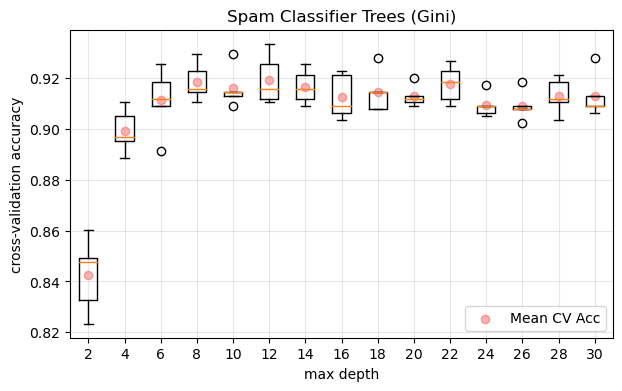

In [13]:
ds = range(first_depth, final_depth + 1, step)

plt.figure(figsize=(7,4))
plt.boxplot([df_gini.loc[df_gini.depth==d, 'all_cv'].values[0] for d in ds])
plt.scatter(range(1,len(ds)+1), df_gini.mean_cv, color='red', alpha=0.3, label='Mean CV Acc')
plt.xticks(range(1,len(ds)+1), labels=ds)
plt.ylabel("cross-validation accuracy")
plt.xlabel("max depth")
plt.title("Spam Classifier Trees (Gini)")
plt.grid(alpha = 0.3)
plt.legend()
plt.show()

**Question:** Which depth are you going to pick?

### Let's extract the best_depth value from these two dataframes, *df_gini* and *df_entropy*.

We need to create the new variable *best_depth* for each dataframe. 

How to get the index of the maximum value from the given array?

```hint: np.argmax(target array)```

In [14]:
# What does this do?

mean_CV_acc_gini = df_gini['mean_cv']
mean_CV_acc_entropy = df_entropy['mean_cv']

best_idx_gini = np.argmax(mean_CV_acc_gini)
best_idx_entropy = np.argmax(mean_CV_acc_entropy)

best_depth_gini = df_gini['depth'].iloc[best_idx_gini]
best_depth_entropy = df_entropy['depth'].iloc[best_idx_entropy]

print('The best depth based on Gini impurity was found to be: ', best_depth_gini)
print('The best depth based on Entropy was found to be: ', best_depth_entropy)

The best depth based on Gini impurity was found to be:  12
The best depth based on Entropy was found to be:  10


In [15]:
#Evalaute the performance at the best depth
model_tree_gini = DecisionTreeClassifier(max_depth=best_depth_gini, criterion = 'gini')
model_tree_entropy = DecisionTreeClassifier(max_depth=best_depth_entropy, criterion ='entropy')

model_tree_gini.fit(X_train, y_train)
model_tree_entropy.fit(X_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set (Gini Impurity)
acc_trees_train_gini = accuracy_score(y_train, model_tree_gini.predict(X_train))
acc_trees_test_gini  = accuracy_score(y_test,  model_tree_gini.predict(X_test))

print("================ [Gini Impurity] ================")
print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_train_gini))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_test_gini))

#Check Accuracy of Spam Detection in Train and Test Set (Entropy)
acc_trees_train_entropy = accuracy_score(y_train, model_tree_entropy.predict(X_train))
acc_trees_test_entropy = accuracy_score(y_test,  model_tree_entropy.predict(X_test))

print("\n================ [Entropy] ================")
print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_train_entropy))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_test_entropy))

================ [Gini Impurity] ================
Simple Decision Trees: Accuracy, Training Set 	 : 97.17%
Simple Decision Trees: Accuracy, Testing Set 	 : 92.18%

================ [Entropy] ================
Simple Decision Trees: Accuracy, Training Set 	 : 96.71%
Simple Decision Trees: Accuracy, Testing Set 	 : 90.45%


### Let's visualize a confusion matrix with ```plot_confusion_matrix```

#### How to visualize the classification result using a Confusion matrix? ####

<img src="fig/confusion_matrix.png" alt="classification error" width="300"/>

<img src="fig/confusion_matrix2.png" alt="classification error" width="400"/>

*source: wikipedia*

We can use the sklearn library function, **plot_confusion_matrix**.

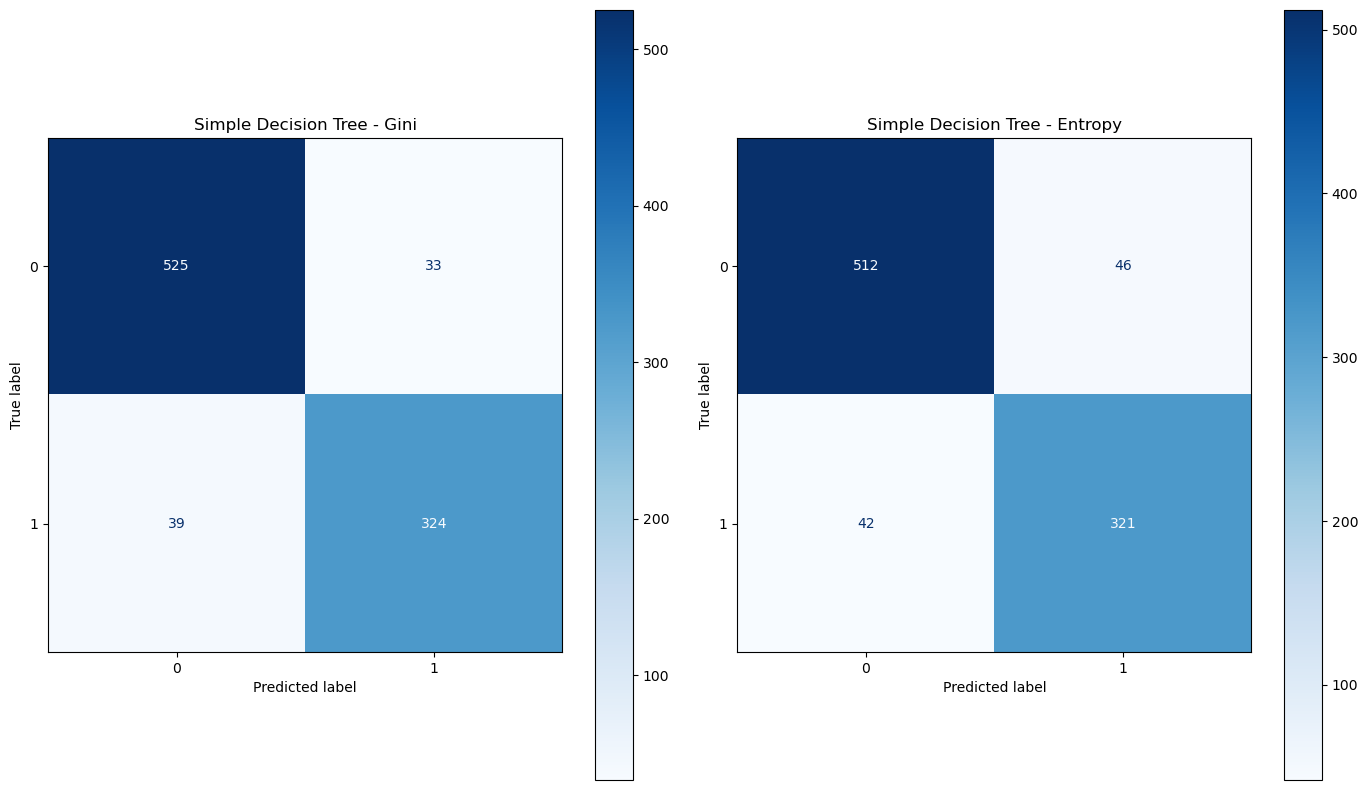

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,8))
ConfusionMatrixDisplay.from_estimator(model_tree_gini, X_test, y_test, cmap=plt.cm.Blues, ax = axes[0]);
ConfusionMatrixDisplay.from_estimator(model_tree_entropy, X_test, y_test, cmap=plt.cm.Blues, ax = axes[1])
axes[0].set_title('Simple Decision Tree - Gini')
axes[1].set_title('Simple Decision Tree - Entropy')
# plt.rc('font', size=18)
plt.tight_layout()

plt.show()

### How to visualize a Decision Tree with ```sklearn.tree.plot_tree```

*Question:* Do you think this tree is interpretable? What do you think about a the maximal depth of the tree?

<!-- - Let's look at the resulting text ```decision_tree.dot``` -->

<!-- - Let's convert our (hard to read) written decision tree (```decision_tree.dot```) into an intuitive image file format: ```image_tree.png```
- <span style="color:red">**NOTE:**</span> You might need to install the ```pydot``` package by typing the following command in your terminal: ```pip install pydot``` or you can install from within the jupyter notebook by running the following cell: ```! pip install pydot``` -->

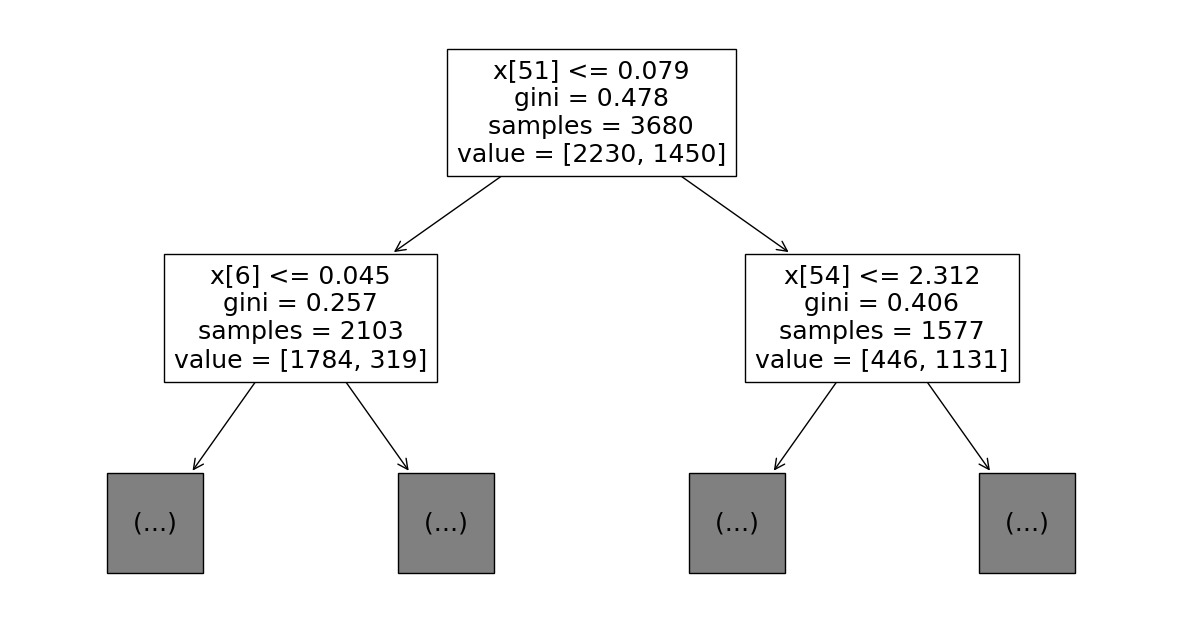

In [17]:
plt.figure(figsize=(15, 8))
gini_tree = tree.plot_tree(model_tree_gini, max_depth = 1);

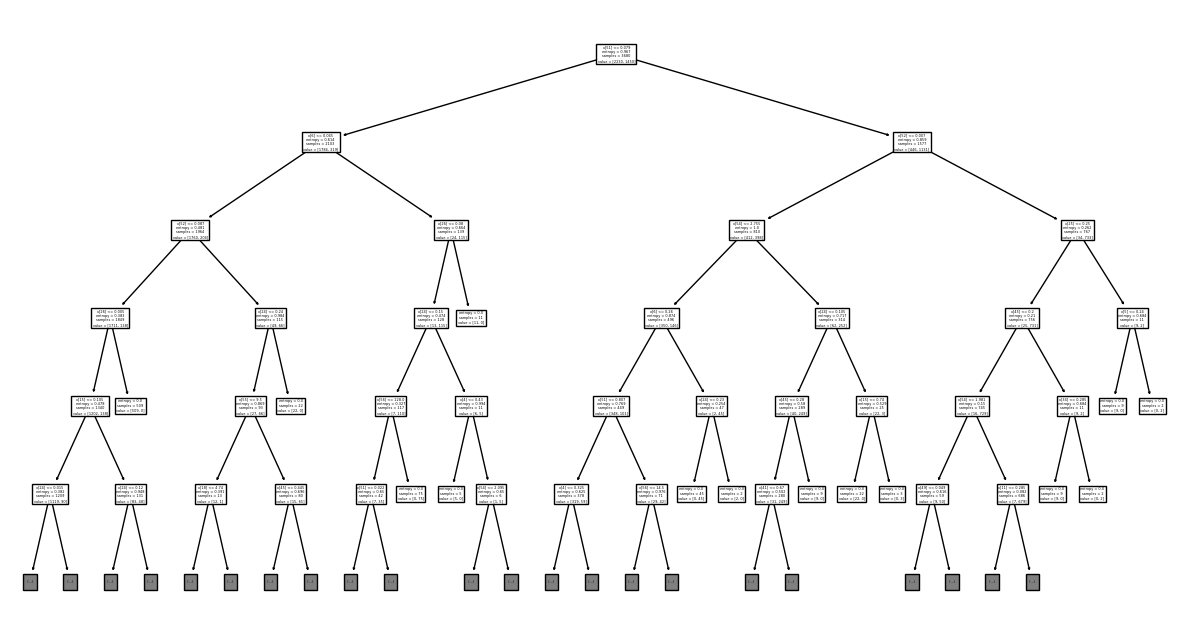

In [18]:
plt.figure(figsize=(15, 8))
entropy_tree = tree.plot_tree(model_tree_entropy, max_depth = 5);

### Pruning

Limiting how far a tree can grow using hyperparameters like `max_depth` or `max_leaf_nodes` can help prevent overfitting, but they can lead to trees with high bias that can underfit the training data.

Another way to address overfitting is to train a deep tree and then prune it back. This is done using the `ccp_alpha` hyperparameter. This is the cost complexity parameter. The cost complexity is the size of the tree. This is analogous to the regularization (hyper)parameter we saw with Ridge and Lasso. A higher value of thehyperparameter means more regularization and a less complex model which is less likely to over fit.

We saw that the optimal entropy tree above was rather deep. But we can prune it back.

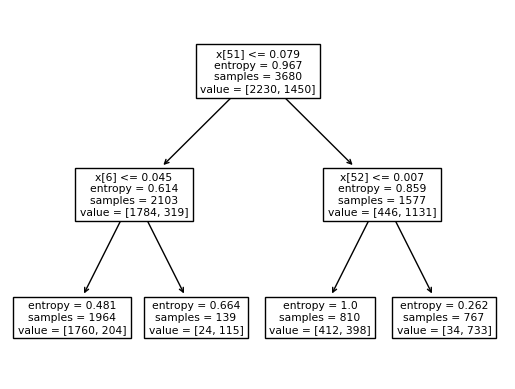

In [19]:
ccp_alpha = 0.05
entropy_pruned = DecisionTreeClassifier(max_depth=best_depth_entropy, criterion ='entropy', ccp_alpha=ccp_alpha)
entropy_pruned.fit(X_train, y_train)
entropy_pruned.score(X_test, y_test)
tree.plot_tree(entropy_pruned);

Minimal cost complexity pruning recursively finds the node with the “weakest link”. The weakest link is characterized by an effective alpha, where the nodes with the smallest effective alpha are pruned first. To get an idea of what values of ccp_alpha could be appropriate, scikit-learn provides [DecisionTreeClassifier.cost_complexity_pruning_path](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.cost_complexity_pruning_path) that returns the effective alphas and the corresponding total leaf impurities at each step of the pruning process. As alpha increases, more of the tree is pruned, which increases the total impurity of its leaves.

In [20]:
path = model_tree_entropy.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

In the following plot, the maximum effective alpha value is removed, because it is the trivial tree with only one node.

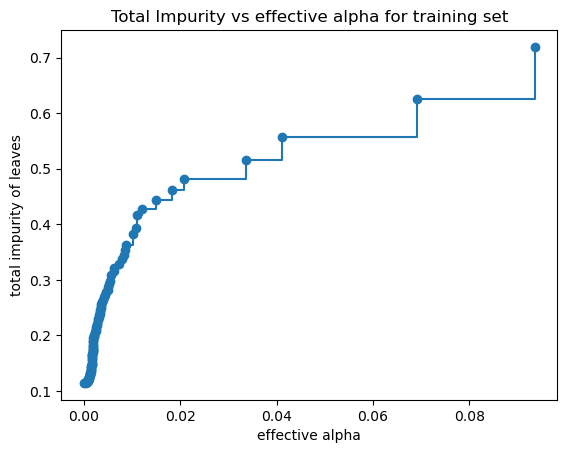

In [21]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set");

Next, we train a decision tree using the effective alphas. The last value in ccp_alphas is the alpha value that prunes the whole tree, leaving the tree, clfs[-1], with one node.

In [22]:
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.24821676693099626


For the remainder of this example, we remove the last element in clfs and ccp_alphas, because it is the trivial tree with only one node. Here we show that the number of nodes and tree depth decreases as alpha increases.

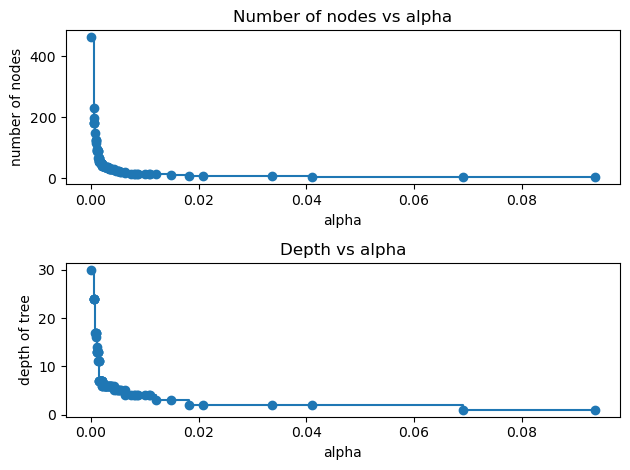

In [23]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

When ccp_alpha is set to zero and keeping the other default parameters of DecisionTreeClassifier, the tree overfits, leading to a 100% training accuracy and 88% testing accuracy. As alpha increases, more of the tree is pruned, thus creating a decision tree that generalizes better. 

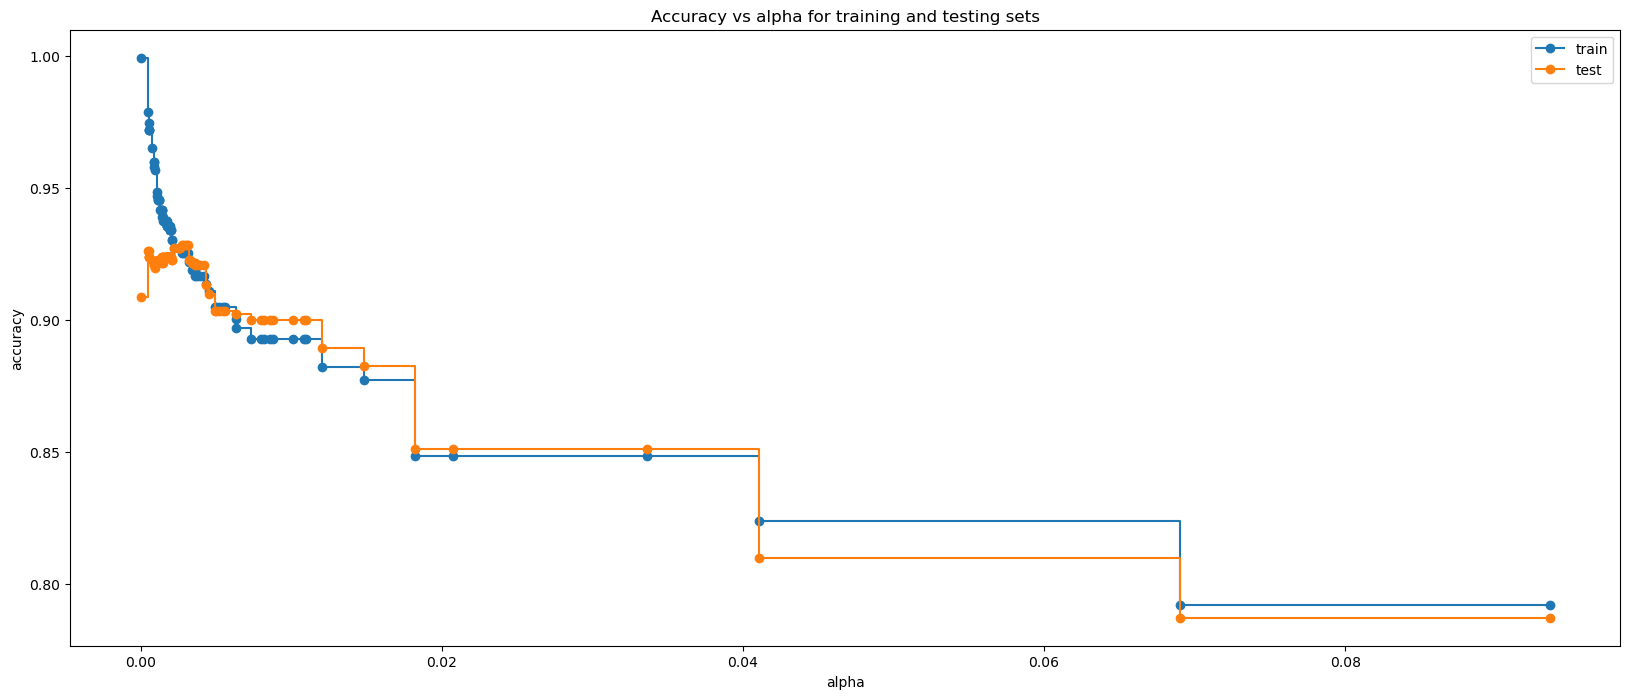

In [24]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots(figsize=(20,8))
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

In [25]:
print(f"ccp_alpha that maximizes test score: {ccp_alphas[np.argmax(test_scores)]:.5f}")

ccp_alpha that maximizes test score: 0.00277



--------


<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY:</strong> Tuning a Spam Detection Decision Tree </div>  

**Tune some of the available decision tree hyperparameters and select the best model. Finally, evaluate your selected model on the test data.**

- You must be able to justify your choice for the best model **without** reference to test performance (i.e., no tuning to the test data!)
- Consult the [DecisionTreeClassifier documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to see the full list of available hyperparameters. You certainly do not need to tune all of them here!

Best Alpha: 0.003000148157188895
Test Score: 0.9305103148751357


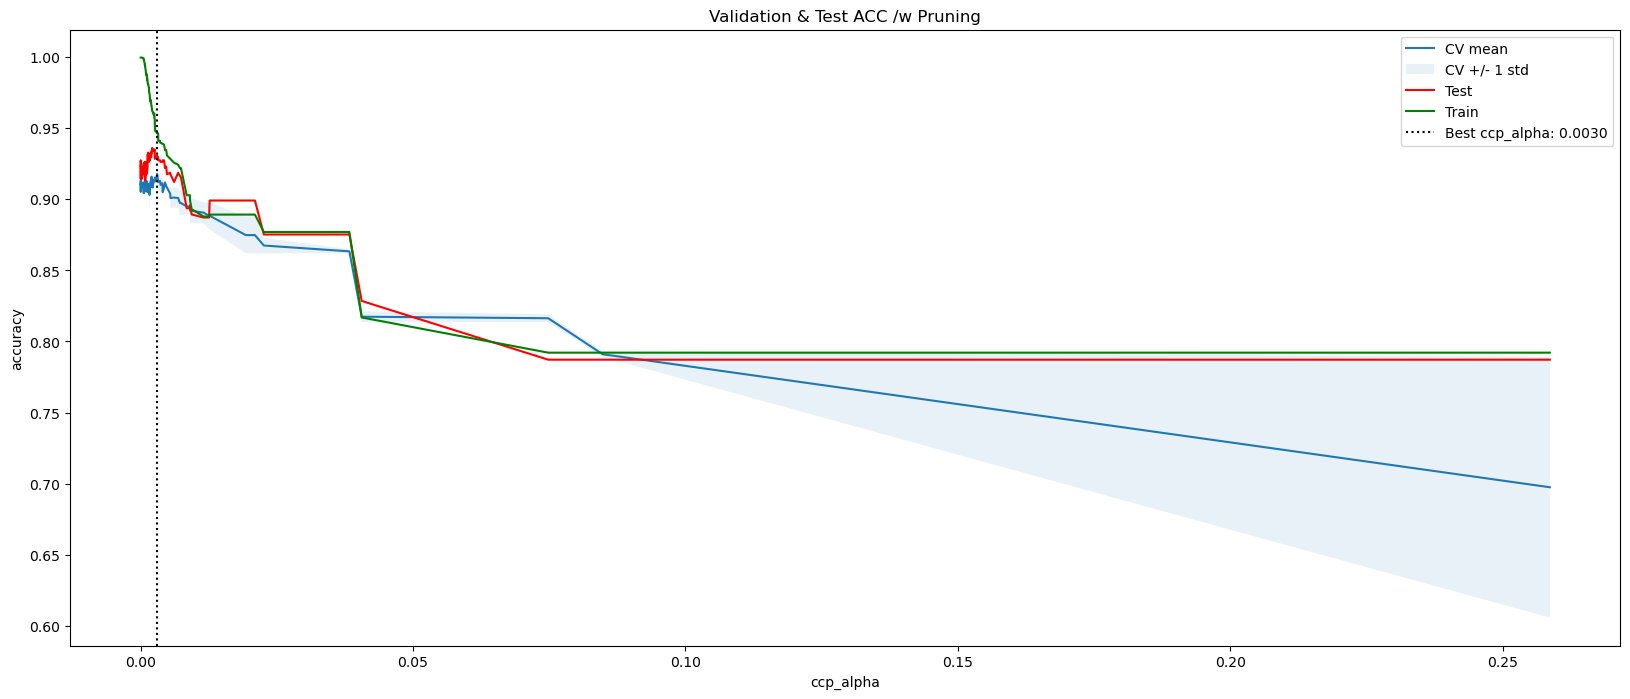

In [26]:
# your code here
params = {'criterion': 'entropy', 'class_weight': 'balanced'}
path = DecisionTreeClassifier(**params).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

cv_accs = []
clfs = []
cv_accs = []

for alpha in ccp_alphas:
    clf = DecisionTreeClassifier(ccp_alpha=alpha, **params).fit(X_train, y_train)
    clfs.append(clf)
    cv_accs.append(cross_val_score(clf, X_train, y_train, cv=2, n_jobs=-1))

cv_accs = np.array(cv_accs)
best_alpha = ccp_alphas[np.argmax(cv_accs.mean(axis=1))]
print("Best Alpha:", best_alpha)

train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

plt.figure(figsize=(20,8))
plt.plot(ccp_alphas, cv_accs.mean(axis=1), label='CV mean')
plt.fill_between(ccp_alphas,
                 cv_accs.mean(axis=1)-cv_accs.std(axis=1),
                 cv_accs.mean(axis=1)+cv_accs.std(axis=1),
                 alpha=.1, 
                label='CV +/- 1 std')
plt.plot(ccp_alphas, test_scores, c='r', label='Test')
plt.plot(ccp_alphas, train_scores, c='g', label='Train')
plt.axvline(best_alpha, c='k', ls=':', label=f'Best ccp_alpha: {best_alpha:.4f}')
plt.xlabel('ccp_alpha')
plt.ylabel('accuracy')
plt.legend()
plt.title("Validation & Test ACC /w Pruning");

print("Test Score:", test_scores[np.argmax(cv_accs.mean(axis=1))])

**Pros of Decision Trees:**
- Very straigtforward models, easy to explain to people, even easier than linear regression.
- Transparent models, easy to interpret
- Not as sensitive to multicollinearity as some other models
- Do not require scaling of data, not sensitive to variables having high difference in range
- Can handle both numerical and caterorical predictors (in some languages like R you don't even have to encode categorical data as zeros and ones, R handles it out-of-the-box)

**Cons of Decision Trees:**
- Not very competitive in terms of predictive accuracy, other classification and regression approaches outperform trees.
- Overfit very quickly.
- Very non-robust, a small change in the data can cause a large change in the final estimated tree, In other words they suffer from high variance.

What can we do to make it better?

Let's say we have a set of $n$ independent observations $Z_1, Z_2, Z_3, ..., Z_n$. Each $Z_i$ has a variance of $\sigma^2$. What would be the variance of the mean of the observations $\bar{Z}$ ?

It would be $\frac{\sigma^2}{n}$, which is lower than each independent observation would have.

## Part 2: Bagging

In part 2 we'll
    2. Fit a Bagging classifer using multiple bootstrapped datasets and do majority voting. 
    3. Evaluate the model on OOB and feature importance.
    
Hopefully after this lab you will be able to answer the following questions: 

- What is the main idea behind bagging?
- Why does bagging help with overfitting?
- Why does bagging help to built more expressive trees?
- What is OOB? How should we use it?
- How can we measure feature importance with trees?


*QUESTION:* Where does the word *"Bagging"* come from?

#### Some Theory: What is bagging?
  1. Bootstrapping: resample with replacements to get different datasets and built different models.
  2. Do something smart to combine the different models.
  
One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results. 

 1. **Bootstrap:** we generate multiple samples of training data, via bootstrapping. We train a full decision tree on each sample of data. 
 2. **AGGregatiING** for a given input, we output the averaged outputs of all the models for that input. 
 
This method is called **Bagging: B** ootstrap + **AGG**regat**ING**. 

-----------

Let's bootstrap our training dataset to create multiple datasets and fit Decision Tree models to each.

(Resampling: we showed live that different samples give different results for things like sums, varying more when the things we sum over have high variance themselves.)


<img src="fig/bagging_array.png" alt="tree_adj" width="80%"/>

In [27]:
# Stat on all data
data_train.mean(axis=0).to_frame('mean').T

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
mean,0.108595,0.209595,0.274962,0.077217,0.303976,0.09834,0.110408,0.105647,0.091937,0.238663,0.060967,0.532228,0.098106,0.058011,0.049114,0.245739,0.145853,0.184405,1.668443,0.092312,0.814883,0.111685,0.102443,0.096899,0.536171,0.265636,0.806652,0.12541,0.095293,0.103541,0.063875,0.046992,0.086421,0.04788,0.110003,0.097682,0.135774,0.009258,0.080375,0.064766,0.043543,0.127128,0.046905,0.072264,0.286598,0.192114,0.005299,0.032671,0.038095,0.138407,0.0147,0.265377,0.076312,0.041596,5.328011,51.172554,283.313859,0.394022


In [28]:
data_train.sample(frac=1., replace=True).mean(axis=0).to_frame('mean').T

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,word_freq_receive,word_freq_will,word_freq_people,word_freq_report,word_freq_addresses,word_freq_free,word_freq_business,word_freq_email,word_freq_you,word_freq_credit,word_freq_your,word_freq_font,word_freq_000,word_freq_money,word_freq_hp,word_freq_hpl,word_freq_george,word_freq_650,word_freq_lab,word_freq_labs,word_freq_telnet,word_freq_857,word_freq_data,word_freq_415,word_freq_85,word_freq_technology,word_freq_1999,word_freq_parts,word_freq_pm,word_freq_direct,word_freq_cs,word_freq_meeting,word_freq_original,word_freq_project,word_freq_re,word_freq_edu,word_freq_table,word_freq_conference,char_freq_,char_freq_.1,char_freq_.2,char_freq_.3,char_freq_.4,char_freq_.5,capital_run_length_average,capital_run_length_longest,capital_run_length_total,spam
mean,0.105402,0.223671,0.277693,0.098783,0.321535,0.094679,0.112264,0.112114,0.095799,0.254489,0.05944,0.541957,0.097383,0.057546,0.052174,0.252364,0.139514,0.180065,1.672527,0.083535,0.833889,0.095783,0.099878,0.098693,0.53362,0.264989,0.697166,0.125954,0.091579,0.115351,0.063277,0.04409,0.094701,0.04503,0.106552,0.093446,0.136073,0.008622,0.084641,0.064201,0.045715,0.135524,0.047209,0.087063,0.304796,0.184022,0.005465,0.041916,0.035405,0.131027,0.01512,0.272856,0.075036,0.041096,5.544942,52.565217,283.627717,0.397011


Now we actually fit the samples

In [29]:
# We can try different values here
n_trees = 100
choosen_depth = 10

In [30]:
# Create a decision tree to serve as the base model in the bagged ensemble
model = DecisionTreeClassifier(max_depth=choosen_depth)

# Initializing arrays to store results
predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

# Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    boot_X = temp.drop(['spam'], axis=1)
    boot_y = temp['spam']
    
    model.fit(boot_X, boot_y)  
    predictions_train[:,i] = model.predict(X_train)   
    predictions_test[:,i] = model.predict(X_test)
    
# Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)

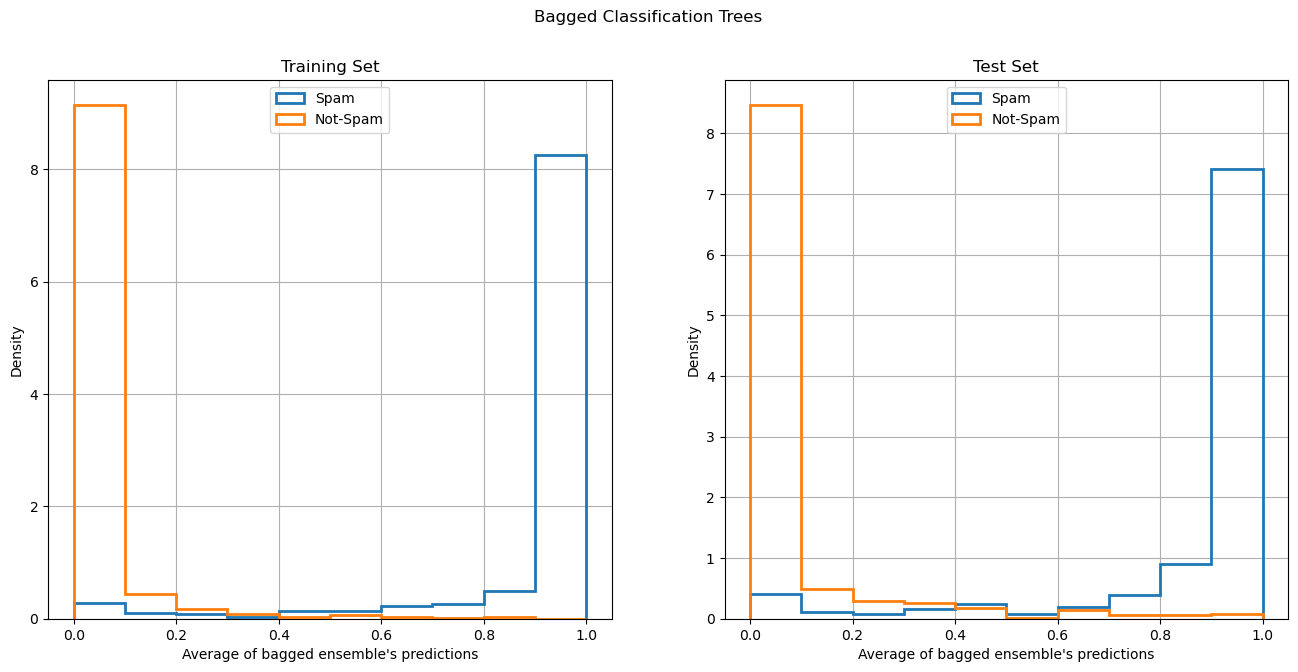

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for (ax, label, predictions, y) in [
    (axs[0], 'Training Set', predictions_train, y_train), 
    (axs[1], 'Test Set' , predictions_test , y_test ) ]:
    
    # Take the average
    mean_predictions = predictions.mean(axis=1)
    
    # Plot the Spam
    mean_predictions[y.values == 1].hist(density=True, histtype='step', 
                                  range=[0,1], label='Spam', lw=2, ax=ax)
    
    # Plot the non Spam
    mean_predictions[y.values == 0].hist(density=True, histtype='step', 
                                  range=[0,1], label='Not-Spam', lw=2, ax=ax)
    ax.legend(loc='upper center');
    ax.set_xlabel("Average of bagged ensemble's predictions")
    ax.set_ylabel("Density")
    ax.set_title(label)
plt.suptitle("Bagged Classification Trees");


And now get final predictions: majority voting!

In [32]:
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df):
    return np.mean(df, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

Bagging: 	Accuracy, Training Set 	: 96.93%
Bagging: 	Accuracy, Testing Set 	: 94.03%


Count in the above code can be use to define the number of models the voting in the dataframe should be based on.

In [33]:
#Get Performance by Class (Lookup Confusion Matrix)
pd.crosstab(np.array(y_test), model.predict(X_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

Predicted,0,1,All
Actual,,,
0,517,41,558
1,47,316,363
All,564,357,921



**Food for Thought :** Are these bagging models independent of each other, can they be trained in a parallel fashion?


### ensemble: a group of items viewed as a whole rather than individually


-------------

### Let's talk about decision trees and bagging in the context of bias and variance.
<img src="fig/bias_variance.png" alt="split2" width="40%"/>
<img src="fig/fitting.png" alt="split2" width="40%"/>

#### When is a decision tree underfit? When is a decision tree overfit? Let's think about this in the concept of tree depth.

#### Bagging enjoys the benefits of 
- High expressiveness (by using larger trees it is able to approximate complex functions and decision boundaries).
- Low _ _ _  by averaging the prediction of all the models thus reducing the _ _ _  in the final prediction.

#### What is the weakness of bagging?
- In practice, the ensemble of trees tend to be **highly ___**
- When could my bagging model be underfit? In what way does this apply to other ensemble methods?





# Part 3: OOB

*QUESTION:* 
- What is out-of-bag (OOB) error? 
- How can we take advantage if it to improve our model's performance?
- Why OOB is a great method?

<img src="fig/oob.png" alt="tree_adj" width="60%"/>

Out-of-bag (OOB) error/Out-of-bag estimate is a method of determining the prediction error that allows the trees to be fit and validated whilst being trained.
OOB samples can be seen as the validation set, generated by bootstrap process. So, we don’t need to do the explicit setup another validation set. Compared to CV, it has the following advantages.

• OOB Error prevents leakage and gives a better model with low variance.

• There is also lesser computational cost for OOB error as compared to CV for bagging. 


In [34]:
def get_oob_prediction(preds, oob_counts):
    oob_idx = oob_counts > 0
    oob_vote = np.sum(preds[oob_idx], axis=1)/oob_counts[oob_idx]
    return oob_vote>0.5

In [35]:
#Creating model
model = DecisionTreeClassifier(max_depth=choosen_depth)

#Initializing variables
predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

predictions_oob = np.zeros(shape = (data_train.shape[0], n_trees))
oob_samples_count = np.zeros(shape = (data_train.shape[0], )) # how many times a sample is in oob

oob_accuracys = []
#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    boot_y = temp['spam']
    boot_X = temp.drop(['spam'], axis=1)
    
    # Train a decision tree
    model.fit(boot_X, boot_y)  
    predictions_train[:,i] = model.predict(X_train)   
    predictions_test[:,i] = model.predict(X_test)
    
    # Get OOB samples
    oob_mask = ~np.isin(data_train.index, temp.index)
    oob_temp = data_train[oob_mask]
    X_oob = oob_temp.drop(['spam'], axis=1) 
    y_oob = oob_temp['spam']
    oob_p = model.predict(X_oob)
    predictions_oob[oob_mask, i] = oob_p # Update prediction results of this tree
    oob_samples_count[oob_mask] += 1 # Increase the count of this sample being OOB
    

acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test))
acc_bagging_oob = 100*accuracy_score(y_train, get_oob_prediction(predictions_oob, oob_samples_count))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_bagging_testing))
print("Bagging: \tAccuracy, OOB Validation Set \t: {:0.2f}%".format(acc_bagging_oob))

Bagging: 	Accuracy, Training Set 	: 97.07%
Bagging: 	Accuracy, Testing Set 	: 94.03%
Bagging: 	Accuracy, OOB Validation Set 	: 93.97%


Food for Thought :

- The essence is that we should predict responses for an observation using each of the trees in which the response is OOB.


# Part 4 Feature Importance

### Feature importance - a quick sneak peek

Details will be covered in lecture on Monday

Decision Tree objects have a `feature_importances_` attribute. This is a record of how much each feature's splits contributed to the reduction in the model's splitting criterion.

The idea is that features whose splits reduced the criterion the most are the most important. But there are reasons to be skeptical about this approach to feature importance...

In [36]:
#Creating model
model = DecisionTreeClassifier(max_depth=choosen_depth)

#Initializing variables
predictions_train = np.zeros( shape = (data_train.shape[0], n_trees))
predictions_test  = np.zeros( shape = (data_test.shape[0],  n_trees))

feature_imp_matrix = []
#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    boot_y = temp['spam']
    boot_X = temp.drop(['spam'], axis=1)
    
    model.fit(boot_X, boot_y)  
    predictions_train[:,i] = model.predict(X_train)   
    predictions_test[:,i] = model.predict(X_test)
    
    # Feature Importance
    single_tree_feature_importance = model.feature_importances_
    feature_imp_matrix.append(single_tree_feature_importance)

# Save as an np.array()
feature_imp_matrix = np.array(feature_imp_matrix)

#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)


In [37]:
feature_imp_mean = feature_imp_matrix.mean(axis = 0)

In [38]:
feature_imp_mean_sorted = list(zip(X_train.columns, feature_imp_mean))
feature_imp_mean_sorted.sort(key = lambda x: -x[1])
for col, val in feature_imp_mean_sorted:
    if val > 0.01:
        print(f'{col}: {val}')

char_freq_.4: 0.23962953183697322
char_freq_.3: 0.23600195700660997
word_freq_remove: 0.1333531961830983
word_freq_hp: 0.056136414599108744
capital_run_length_average: 0.05263579578745867
word_freq_free: 0.03869139118205347
capital_run_length_longest: 0.028342446547072197
word_freq_edu: 0.02598800618709459
capital_run_length_total: 0.018062310378761257
word_freq_money: 0.014900854416388245
word_freq_our: 0.014014516744893693
word_freq_george: 0.013502066541480366
word_freq_your: 0.013274566557302445
word_freq_meeting: 0.011267084357404861


*QUESTION:*

- For each run of the bagging algorithm, should we expect the importance of the features to be the same?
- Why might we not always be able to trust this method for determining feature importance.
- Can you anticipate another way to assess feature importance? (Hint: we've seen it before)

### SKLearn's BaggingClassifier

From SKlearn's [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html):

"A Bagging classifier is an ensemble meta-estimator that fits base classifiers each on random subsets of the original dataset and then aggregate their individual predictions (either by voting or by averaging) to form a final prediction. Such a meta-estimator can typically be used as a way to reduce the variance of a black-box estimator (e.g., a decision tree), by introducing randomization into its construction procedure and then making an ensemble out of it."

The most important arguments are `estimator` which defines the base estimators from which the bagged ensemble is composed and well as `n_estimators`, the number of estimators in the ensemble.
If you want access to the `oob_score_` attribute on the fitted BaggingCLassifier you will also need to set `oob_score=True` since it is `False` by default to save a bit of computation.

The individual estimators in the ensemble can be accessed by the `estimators_` attribute.

`warm_start=True` will cause the BaggingClassifier to re-use the previous estimators when re-fitting with a larger setting of `n_estimators`. This saves computation as you only need to fit the new trees being added to the ensemble.

In [39]:
# Define a BaggingClassifier using a DecisionTreeClassifier as its base estimator
bag = BaggingClassifier(estimator=DecisionTreeClassifier(),
                  n_estimators=100,
                  oob_score=True)

In [40]:
# Fit on train
bag.fit(X_train, y_train)

BaggingClassifier(estimator=DecisionTreeClassifier(), n_estimators=100,
                  oob_score=True)

In [41]:
# Inspect OOB accuracy
print("OOB ACC:", bag.oob_score_)

OOB ACC: 0.9475543478260869


In [42]:
# Inspect test accuracy
print("Test ACC:", bag.score(X_test, y_test))

Test ACC: 0.9391965255157437


<div class="alert alert-success">
    <strong>🏋🏻‍♂️ TEAM ACTIVITY 2:</strong> Number of Estimator's Affect on BaggingClassifier </div>  

- Create a visualization showing how the number of estimators effects the bagging classifier's train and test scores.
- You should use the default, 'full-depth' trees as your base estimators.
- There are many ways to accomplish this!

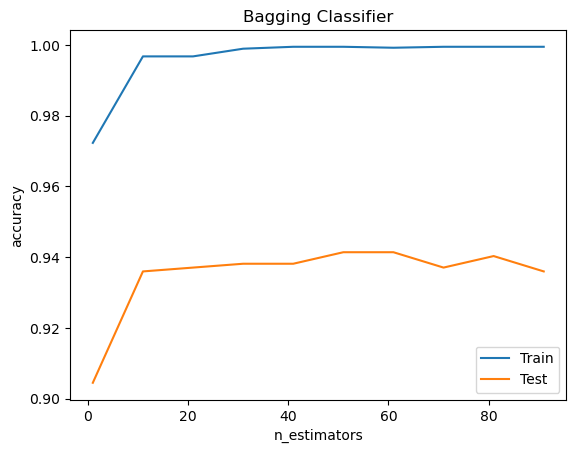

In [43]:
# your code here
max_estimators = 100
step = 10
train_scores = []
oob_scores = []
test_scores = []
for n in range(1, max_estimators+1, step):
    bag = BaggingClassifier(estimator=DecisionTreeClassifier(),
                      n_estimators=n,
                      # oob_score=True,
                      warm_start=True)
    bag.fit(X_train, y_train)
    train_scores.append(bag.score(X_train, y_train))
    test_scores.append(bag.score(X_test, y_test))
    # oob_scores.append(bag.oob_score_)
    

plt.plot(range(1, max_estimators+1, step), train_scores, label='Train')
plt.plot(range(1, max_estimators+1, step), test_scores, label='Test')
plt.xlabel('n_estimators')
plt.ylabel('accuracy')
plt.legend()
plt.title("Bagging Classifier");

🤔 **Closing Questions**:
- Might there be something wrong with using accuracy to evaluate our spam classifier?
- Can you think of a way to further reduce the variance of the ensemble model?